In [1]:
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import layers, models, regularizers
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
# Constants
BATCH_SIZE = 8
IMG_SIZE = (224, 224)
AUTOTUNE = tf.data.AUTOTUNE


# 1. Load dataset (no oversampling)
train_path = r'D:/crimeAnomoly/Train/Train'
test_path = r'D:/crimeAnomoly/Test/Test'

train_ds = image_dataset_from_directory(
    train_path,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

val_ds = image_dataset_from_directory(
    train_path,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

class_names = train_ds.class_names
IMG_SIZE = (224, 224)
AUTOTUNE = tf.data.AUTOTUNE

Found 1266345 files belonging to 14 classes.
Using 1013076 files for training.
Found 1266345 files belonging to 14 classes.
Using 253269 files for validation.


In [3]:
# 2. Data augmentation
augmentation_layer = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
])

train_ds = train_ds.map(lambda x, y: (augmentation_layer(x, training=True), y))
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

In [4]:
# 3. Compute class weights
all_labels = []
for _, labels in train_ds.unbatch():
    all_labels.append(int(labels.numpy()))

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(all_labels),
    y=all_labels
)
class_weights_dict = dict(enumerate(class_weights))


In [5]:
# 4. Build model with fine-tuning and regularization
base_model = tf.keras.applications.ResNet50(input_shape=IMG_SIZE + (3,), include_top=False, weights='imagenet')
base_model.trainable = True
for layer in base_model.layers[:-30]:  # Freeze all layers except the last 30
    layer.trainable = False

def get_model():
    inputs = tf.keras.Input(shape=(224, 224, 3))
    x = tf.keras.applications.resnet.preprocess_input(inputs)
    x = base_model(x, training=True)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(len(class_names), activation='softmax')(x)
    return tf.keras.Model(inputs, outputs)

model = get_model()
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


In [6]:
# 5. Callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(patience=3, factor=0.2)
]


In [7]:
# 6. Train
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=8,
    callbacks=callbacks,
    class_weight=class_weights_dict
)

Epoch 1/8
126635/126635 [==============================] - 13679s 108ms/step - loss: 0.6241 - accuracy: 0.7906 - val_loss: 0.5459 - val_accuracy: 0.8511 - lr: 1.0000e-04
Epoch 2/8
126635/126635 [==============================] - 13232s 104ms/step - loss: 0.1561 - accuracy: 0.9412 - val_loss: 0.4592 - val_accuracy: 0.8731 - lr: 1.0000e-04
Epoch 3/8
126635/126635 [==============================] - 13255s 105ms/step - loss: 0.1155 - accuracy: 0.9620 - val_loss: 0.4341 - val_accuracy: 0.8847 - lr: 1.0000e-04
Epoch 4/8
126635/126635 [==============================] - 13351s 105ms/step - loss: 0.1014 - accuracy: 0.9693 - val_loss: 0.4765 - val_accuracy: 0.8782 - lr: 1.0000e-04
Epoch 5/8
126635/126635 [==============================] - 13609s 107ms/step - loss: 0.0900 - accuracy: 0.9750 - val_loss: 0.6174 - val_accuracy: 0.8291 - lr: 1.0000e-04
Epoch 6/8
126635/126635 [==============================] - 13574s 107ms/step - loss: 0.0840 - accuracy: 0.9780 - val_loss: 0.4264 - val_accuracy: 0.88

13914/13914 [==============================] - 645s 46ms/step


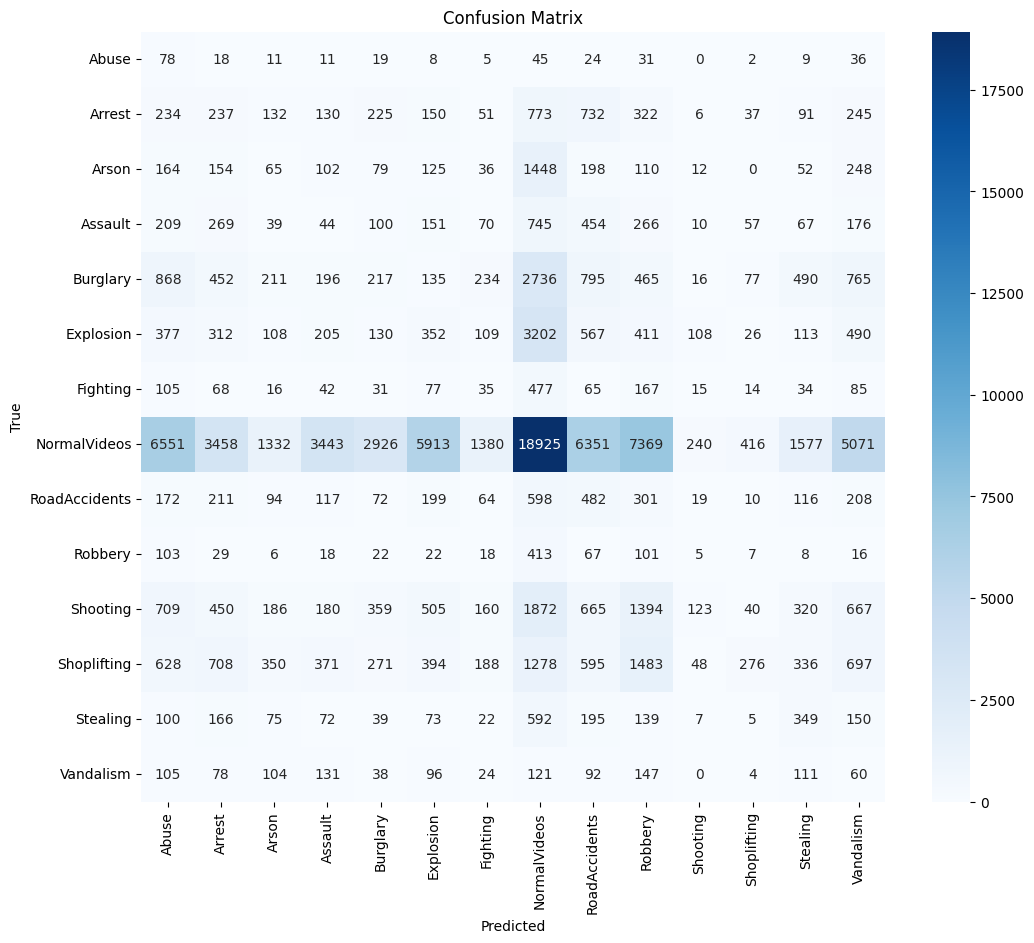


Classification Report:
               precision    recall  f1-score   support

        Abuse       0.01      0.26      0.01       297
       Arrest       0.04      0.07      0.05      3365
        Arson       0.02      0.02      0.02      2793
      Assault       0.01      0.02      0.01      2657
     Burglary       0.05      0.03      0.04      7657
    Explosion       0.04      0.05      0.05      6510
     Fighting       0.01      0.03      0.02      1231
 NormalVideos       0.57      0.29      0.39     64952
RoadAccidents       0.04      0.18      0.07      2663
      Robbery       0.01      0.12      0.01       835
     Shooting       0.20      0.02      0.03      7630
  Shoplifting       0.28      0.04      0.06      7623
     Stealing       0.10      0.18      0.12      1984
    Vandalism       0.01      0.05      0.01      1111

     accuracy                           0.19    111308
    macro avg       0.10      0.10      0.06    111308
 weighted avg       0.38      0.19     

In [9]:
# 8. Confusion Matrix & Classification Report
y_true = np.concatenate([y.numpy() for x, y in test_ds])
y_pred = np.argmax(model.predict(test_ds), axis=1)

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))


In [10]:
# Save the trained model
model.save("my_model.keras")

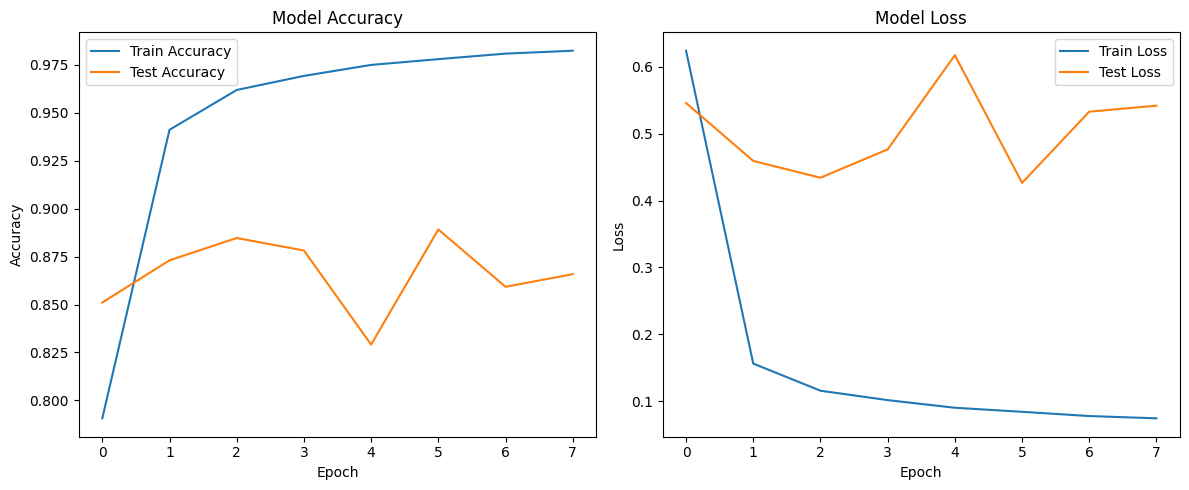

In [11]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()
